# TODO: Document
# TODO: Cleanup
* Note, this script may take several days to run
* TODO: Document the related-signal residualization

In [1]:
# CHANGE THIS PARAMETER
username = "taapaye"

In [2]:
import functools
import os
import pickle
import random

import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
import statsmodels.formula.api as smf
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm


@functools.wraps(smf.ols)
def lm(*args, **kwargs):
    return smf.ols(*args, **kwargs).fit()

In [3]:
np.random.seed(0)

In [4]:
os.chdir(f"../../data/recommendations/{username}")

In [ ]:
filtered_df = pickle.load(open("../../processed_data/user_anime_lists.pkl", "rb"))
user_df = pickle.load(open("user_anime_list.pkl", "rb"))
filtered_df = filtered_df.loc[lambda x: ~x["username"].isin(user_df.username)]
filtered_df = pd.concat([filtered_df, user_df], ignore_index=True)
filtered_df = filtered_df.set_index("username")

In [6]:
related_df = pickle.load(open("related_loocv.pkl", "rb"))

In [7]:
@functools.lru_cache()
def get_item_corrs(nonneg_corrs=False):
    corrs = pickle.load(open("../../processed_data/item_correlations.pkl", "rb"))
    if nonneg_corrs:
        corrs["similarity"] = corrs["corr"]
    else:
        corrs["similarity"] = corrs["corr"].abs()
    corrs = corrs.dropna()
    corrs = corrs.loc[
        lambda x: x.index.get_level_values("anime_id_x")
        != x.index.get_level_values("anime_id_y")
    ]
    corrs = corrs.sort_values(by="similarity")
    return corrs


def get_item_corrs_wrapper(df, username):
    return get_item_corrs()


def get_item_scores(df, corrs, username, neighborhood_size):
    corrs = corrs.groupby("anime_id_x").tail(neighborhood_size)
    score = df.loc[username].merge(
        corrs.reset_index("anime_id_x"), left_on="anime_id", right_on="anime_id_y",
    )
    score = score.drop("anime_id", axis=1).rename({"anime_id_x": "anime_id"}, axis=1)
    return score

In [8]:
def get_user_corrs(df, username, nonneg_corrs=False):
    user_subset = df.loc[[username]].merge(df.reset_index(), on="anime_id")
    corr_numerator = user_subset.groupby("username").apply(
        lambda x: np.dot(x["score_x"], x["score_y"])
    )
    corr_denom = df.groupby("username").apply(
        lambda x: np.sqrt(np.dot(x["score"], x["score"]))
    )
    corr_denom *= corr_denom.loc[username]
    corrs = pd.DataFrame((corr_numerator / corr_denom), columns=["corr"])
    if nonneg_corrs:
        corrs["similarity"] = corrs["corr"]
    else:
        corrs["similarity"] = corrs["corr"].abs()
    corrs["corr_size"] = user_subset.groupby("username").size()
    corrs = corrs.drop(username)
    corrs = corrs.dropna()
    corrs = corrs.loc[lambda x: x["corr_size"] > 2]
    corrs = corrs.sort_values(by="similarity")
    return corrs


def get_user_scores(df, corrs, recommendee, neighborhood_size):
    corrs = corrs[-neighborhood_size:]
    score = (df.merge(pd.DataFrame(corrs), on="username")).dropna()
    return score

In [9]:
def get_delta(score):
    return score.groupby("anime_id").apply(
        lambda x: np.dot(x["score"], x["corr"]) / x["corr"].abs().sum()
    )

In [10]:
def get_squared_error(df, pred_df, username):
    pred_df = pred_df.loc[pred_df.index.intersection(df.loc[username].anime_id)]
    pred_df = pred_df.merge(
        df.loc[username].set_index("anime_id")["score"], on="anime_id"
    )
    errors = pred_df["pred_score"] - pred_df["score"]
    return np.dot(errors, errors)

In [11]:
def compute_accuracy_metrics(
    is_df, oos_df, score_fn, corrs_fn, username, neighborhood_sizes,
):
    corrs = corrs_fn(is_df, username)
    metrics = pd.DataFrame()
    for neighborhood_size in tqdm(
        reversed(sorted(neighborhood_sizes)), total=len(neighborhood_sizes),
    ):
        score = score_fn(is_df, corrs, username, neighborhood_size)
        pred_df = pd.DataFrame()
        pred_df["related"] = related_df['delta']        
        pred_df["delta"] = get_delta(score)
        pred_df = pred_df.fillna(0)

        # train linear model
        seen_shows = is_df.loc[username].merge(pred_df, on='anime_id')
        model = lm("score ~ delta + related", seen_shows)

        # inference
        pred_df["pred_score"] = model.predict(pred_df)
        is_pred_df = pred_df.loc[lambda x: x.index.isin(is_df.loc[username].anime_id)]
        oos_pred_df = pred_df.loc[lambda x: x.index.isin(oos_df.anime_id)]

        # compute coverage
        is_coverage = len(is_pred_df.loc[lambda x: ~np.isclose(x['delta'], 0)]) / len(is_df.loc[username])
        oos_coverage = len(oos_pred_df.loc[lambda x: ~np.isclose(x['delta'], 0)]) / len(oos_df)

        # compute rmse
        # TODO delete the 'missing' components as nothing should be missing anymore
        missing_is = is_df.loc[username].loc[
            lambda x: ~x.anime_id.isin(is_pred_df.index)
            & ~x.anime_id.isin(oos_df.anime_id)
        ]
        missing_oos = oos_df.loc[lambda x: ~x.anime_id.isin(oos_pred_df.index)]
        is_se = get_squared_error(is_df, is_pred_df, username)
        oos_se = get_squared_error(oos_df, oos_pred_df, username)
        missing_is_se = np.dot(missing_is["score"], missing_is["score"])
        missing_oos_se = np.dot(missing_oos["score"], missing_oos["score"])
        is_rmse = np.sqrt((is_se + missing_is_se) / len(is_df.loc[username]))
        oos_rmse = np.sqrt((oos_se + missing_oos_se) / len(oos_df))
        metrics = metrics.append(
            {
                "neighborhood_size": neighborhood_size,
                "is_rsquared": model.rsquared_adj,
                "is_rmse": is_rmse,
                "is_coverage": is_coverage,
                "oos_rmse": oos_rmse,
                "oos_coverage": oos_coverage,
            },
            ignore_index=True,
        )

    return metrics

In [12]:
K = 10
base = np.sqrt(2)

errors_by_neighborhood_size = []
max_size = len(filtered_df.anime_id.unique())
neighborhood_sizes = [
    int(base ** i) for i in range(int(np.log(max_size) / np.log(base)) + 1)
] + [max_size]
neighborhood_sizes = sorted(list(set(neighborhood_sizes)))
splits = np.array_split(filtered_df.loc[username].sample(frac=1), K)

for split in splits:
    oos_df = split
    is_df = filtered_df.loc[
        lambda x: ~(
            (x.index.get_level_values("username") == username)
            & x.anime_id.isin(oos_df.anime_id)
        )
    ]
    
    item_metrics = compute_accuracy_metrics(
        is_df.copy(),
        oos_df.copy(),
        get_item_scores,
        get_item_corrs_wrapper,
        username,
        neighborhood_sizes,
    )
    item_metrics["signal"] = "item"
    errors_by_neighborhood_size.append(item_metrics)    

    user_metrics = compute_accuracy_metrics(
        is_df.copy(),
        oos_df.copy(),
        get_user_scores,
        get_user_corrs,
        username,
        neighborhood_sizes,
    )
    user_metrics["signal"] = "user"
    errors_by_neighborhood_size.append(user_metrics)

100%|██████████| 27/27 [14:08<00:00, 31.44s/it]

100%|██████████| 27/27 [14:19<00:00, 31.83s/it]

100%|██████████| 27/27 [14:46<00:00, 32.82s/it]

100%|██████████| 27/27 [14:30<00:00, 32.25s/it]

100%|██████████| 27/27 [17:42<00:00, 39.34s/it]

100%|██████████| 27/27 [17:58<00:00, 39.94s/it]

100%|██████████| 27/27 [15:51<00:00, 35.23s/it]

100%|██████████| 27/27 [15:28<00:00, 34.38s/it]

100%|██████████| 27/27 [16:11<00:00, 35.97s/it]

100%|██████████| 27/27 [15:09<00:00, 33.69s/it]

100%|██████████| 10/10 [3:19:03<00:00, 1194.34s/it]


In [13]:
allerrors = pd.concat(errors_by_neighborhood_size, ignore_index=True)

## Visualizations

In [14]:
wide_data = pd.melt(allerrors, ["neighborhood_size", "signal"])

In [15]:
for signal in wide_data["signal"].unique():
    wide_data.loc[lambda x: x["signal"] == signal, "variable"] = (
        f"{signal}_" + wide_data.loc[lambda x: x["signal"] == signal, "variable"]
    )

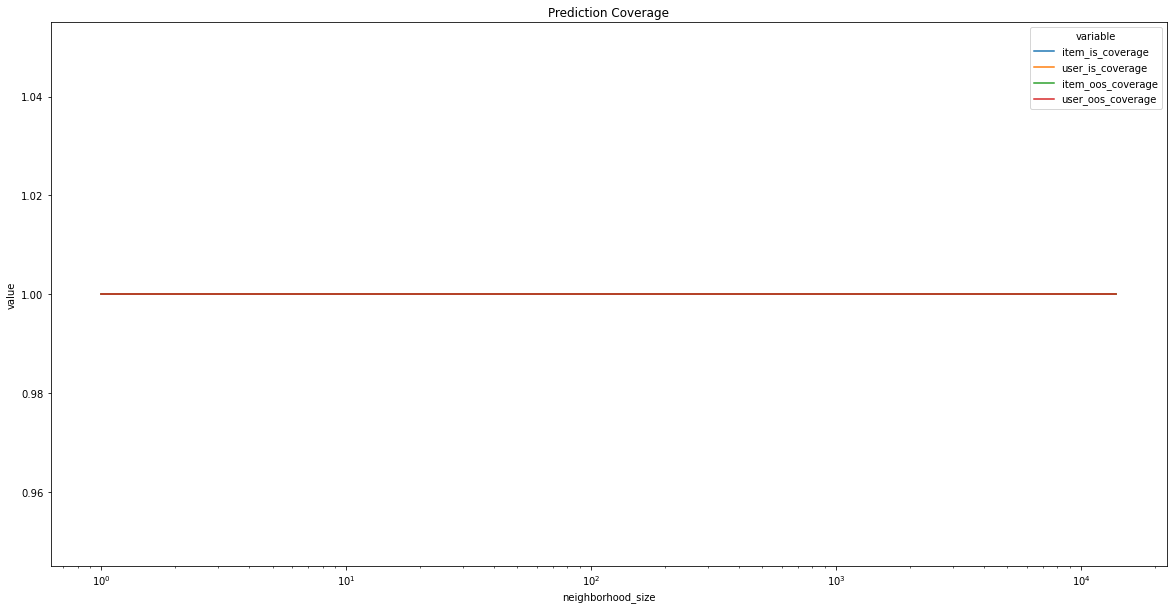

In [16]:
plt.figure(figsize=(20, 10))
_ = sns.lineplot(
    x="neighborhood_size",
    y="value",
    hue="variable",
    data=wide_data.loc[lambda x: x.variable.str.contains("coverage")],
).set(xscale="log", title="Prediction Coverage")

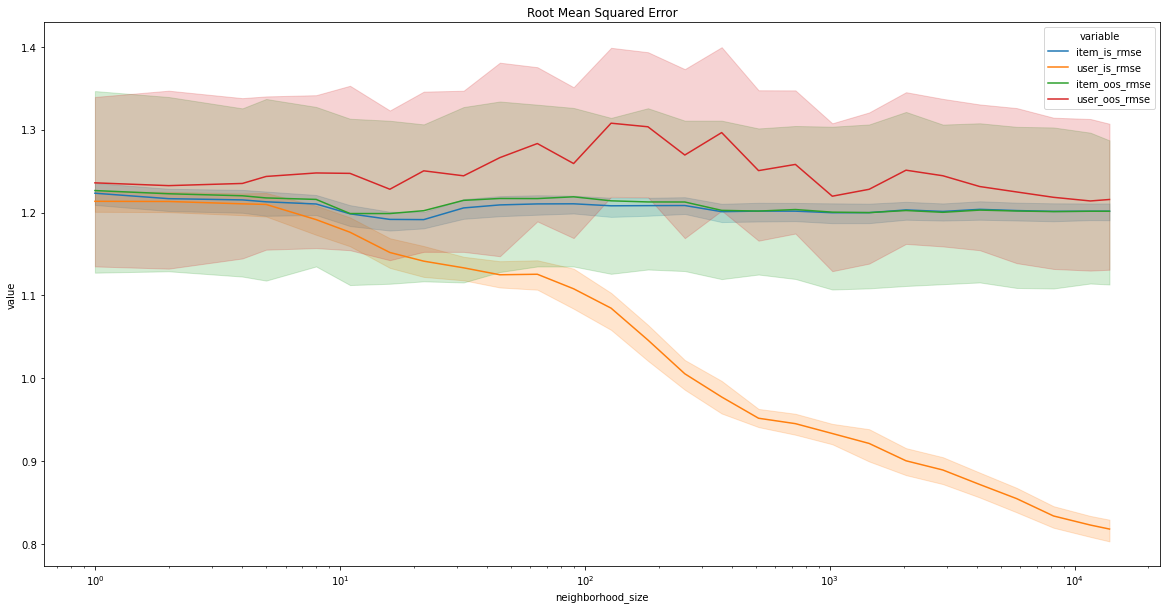

In [17]:
plt.figure(figsize=(20, 10))
_ = sns.lineplot(
    x="neighborhood_size",
    y="value",
    hue="variable",
    data=wide_data.loc[lambda x: x.variable.str.contains("rmse")],
).set(xscale="log", title="Root Mean Squared Error")

In [26]:
allerrors.groupby(["signal", "neighborhood_size"]).mean().sort_values(
    by="oos_rmse"
).head(50)

is_coverage   is_rmse  is_rsquared  oos_coverage  \
signal neighborhood_size                                                     
item   16.0                       1.0  1.191781     0.173213           1.0   
       11.0                       1.0  1.198519     0.163908           1.0   
       1448.0                     1.0  1.199939     0.161878           1.0   
       2896.0                     1.0  1.201380     0.159898           1.0   
       1024.0                     1.0  1.199850     0.162011           1.0   
       8192.0                     1.0  1.201486     0.159728           1.0   
       13865.0                    1.0  1.201625     0.159530           1.0   
       11585.0                    1.0  1.201636     0.159515           1.0   
       512.0                      1.0  1.201818     0.159290           1.0   
       5792.0                     1.0  1.202464     0.158380           1.0   
       22.0                       1.0  1.191537     0.173487           1.0   
       2048.0                     1.0  1.203210     0.157337           1.0   
       362.0                      1.0  1.201117     0.160259           1.0   
       4096.0                     1.0  1.203923     0.156326           1.0   
       724.0                      1.0  1.201737     0.159414           1.0   
       256.0                      1.0  1.208537     0.149853           1.0   
       181.0                      1.0  1.208403     0.150063           1.0   
user   11585.0                    1.0  0.822859     0.605934           1.0   
item   128.0                      1.0  1.208196     0.150345           1.0   
       32.0                       1.0  1.205630     0.153960           1.0   
user   13865.0                    1.0  0.818029     0.610554           1.0   
item   8.0                        1.0  1.210385     0.147242           1.0   
       64.0                       1.0  1.210480     0.147146           1.0   
       45.0                       1.0  1.209274     0.148832           1.0   
       5.0                        1.0  1.213015     0.143650           1.0   
user   8192.0                     1.0  0.833830     0.595383           1.0   
item   90.0                       1.0  1.210613     0.146944           1.0   
user   1024.0                     1.0  0.933355     0.492756           1.0   
item   4.0                        1.0  1.215314     0.140372           1.0   
       2.0                        1.0  1.216802     0.138247           1.0   
user   5792.0                     1.0  0.854777     0.574761           1.0   
item   1.0                        1.0  1.223386     0.128941           1.0   
user   1448.0                     1.0  0.921359     0.505740           1.0   
       16.0                       1.0  1.151848     0.227461           1.0   
       4096.0                     1.0  0.871803     0.557642           1.0   
       2.0                        1.0  1.213416     0.143024           1.0   
       4.0                        1.0  1.210565     0.147018           1.0   
       1.0                        1.0  1.213614     0.142738           1.0   
       5.0                        1.0  1.209852     0.148027           1.0   
       32.0                       1.0  1.133330     0.252219           1.0   
       2896.0                     1.0  0.889307     0.539608           1.0   
       11.0                       1.0  1.176288     0.194276           1.0   
       8.0                        1.0  1.191532     0.173634           1.0   
       22.0                       1.0  1.141385     0.241362           1.0   
       512.0                      1.0  0.951778     0.472505           1.0   
       2048.0                     1.0  0.900425     0.528088           1.0   
       724.0                      1.0  0.945251     0.479700           1.0   
       90.0                       1.0  1.108040     0.285012           1.0   
       45.0                       1.0  1.124947     0.263239           1.0   
       256.0                      1.0  1.005450 

In [40]:
allerrors.groupby(["signal", "neighborhood_size"]).mean().rolling(3).mean().xs('item', level='signal').sort_values(by='oos_rmse')

,is_coverage,is_rmse,is_rsquared,oos_coverage,oos_rmse
neighborhood_size,,,,,
22.0,1.0,1.193946,0.170202,1.0,1.199999
2896.0,1.0,1.201510,0.159704,1.0,1.200940
2048.0,1.0,1.201000,0.160409,1.0,1.201001
1448.0,1.0,1.200509,0.161101,1.0,1.201395
13865.0,1.0,1.201582,0.159591,1.0,1.201473
11585.0,1.0,1.201862,0.159207,1.0,1.201574
5792.0,1.0,1.202589,0.158201,1.0,1.201755
4096.0,1.0,1.202838,0.157854,1.0,1.201956
1024.0,1.0,1.201135,0.160239,1.0,1.202012


In [23]:
(1.199971 + 1.200345 + 1.200527) / 3

1.2002810000000002

In [22]:
(1.198847 + 1.198858 + 1.202293 ) / 3

1.1999993333333334

## Store best hyperparameters

In [19]:
allerrors.groupby(["signal", "neighborhood_size"]).mean().sort_values(
    by="oos_rmse"
).reset_index().groupby("signal").first()

,neighborhood_size,is_coverage,is_rmse,is_rsquared,oos_coverage,oos_rmse
signal,,,,,,
item,16.0,1.0,1.191781,0.173213,1.0,1.198847
user,11585.0,1.0,0.822859,0.605934,1.0,1.214040


In [2]:
outdir = "parameters"
if not os.path.exists(outdir):
    os.mkdir(outdir)
os.chdir(outdir)

In [21]:
allerrors.groupby(["signal", "neighborhood_size"]).mean().sort_values(
    by="oos_rmse"
).reset_index().groupby("signal").first().to_pickle("neighborhoodcf.best.pkl")
allerrors.to_pickle("neighborhoodcf.all.pkl")

In [5]:
1

1

In [37]:
all_errors = pickle.load(open('parameters/neighborhoodcf.all.pkl', 'rb'))

In [38]:
all_errors = all_errors.loc[lambda x:x['signal'] == 'item']

In [39]:
all_errors.groupby(["neighborhood_size"]).mean().rolling(5, center=True).mean().sort_values(by='oos_rmse')

,is_coverage,is_rmse,is_rsquared,oos_coverage,oos_rmse
neighborhood_size,,,,,
2048.0,1.0,1.201660,0.159490,1.0,1.201273
1448.0,1.0,1.201223,0.160108,1.0,1.201407
2896.0,1.0,1.202183,0.158764,1.0,1.201548
5792.0,1.0,1.202178,0.158769,1.0,1.201617
1024.0,1.0,1.201311,0.159986,1.0,1.201703
724.0,1.0,1.200892,0.160571,1.0,1.201739
4096.0,1.0,1.202492,0.158334,1.0,1.201794
8192.0,1.0,1.202226,0.158696,1.0,1.201868
512.0,1.0,1.202612,0.158166,1.0,1.204299


In [14]:
all_errors.groupby('neighborhood_size').mean().sort_values(by='oos_rmse')

,is_coverage,is_rmse,is_rsquared,oos_coverage,oos_rmse
neighborhood_size,,,,,
16.0,1.0,1.191781,0.173213,1.0,1.198847
11.0,1.0,1.198519,0.163908,1.0,1.198858
1448.0,1.0,1.199939,0.161878,1.0,1.199971
2896.0,1.0,1.201380,0.159898,1.0,1.200345
1024.0,1.0,1.199850,0.162011,1.0,1.200527
8192.0,1.0,1.201486,0.159728,1.0,1.201198
13865.0,1.0,1.201625,0.159530,1.0,1.201599
11585.0,1.0,1.201636,0.159515,1.0,1.201621
512.0,1.0,1.201818,0.159290,1.0,1.201824
